## Load the tokenizer

In [2]:
import sys
sys.path.append('..')

In [3]:
from minbpe import BasicTokenizer

tokenizer = BasicTokenizer()
tokenizer.load(model_file="./output/tokenizer/my_tokenizer.model")


def get_vocab_size(tokenizer: BasicTokenizer) -> int:
    vocab = tokenizer.vocab
    special_tokens = tokenizer.special_tokens

    return len(vocab) + len(special_tokens)

## Create the model

In [4]:
import torch
torch.manual_seed(3647)

In [5]:
import torch._dynamo
torch._dynamo.config.suppress_errors = True

In [6]:
from transformer.model import GPTLanguageModel

block_size = 256
n_embd = 512
n_head = 12
n_layer = 4
dropout = 0.2
batch_size = 64
vocab_size = get_vocab_size(tokenizer)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = GPTLanguageModel(
    vocab_size=vocab_size,
    block_size=block_size,
    n_embd=n_embd,
    n_head=n_head,
    n_layer=n_layer,
    dropout=dropout,
    device=device
).to(device)
# model = torch.compile(model)

print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')

13.727752 M parameters


## Data preparation

### 1. Load the data

In [7]:
with open("./output/combined_text.txt", "r") as f:
    text_sequence = f.read()

encoded_text_sequence = tokenizer.encode(text_sequence)
len(encoded_text_sequence)

57180

### 2. Split it into train and test

In [8]:
data = torch.tensor(encoded_text_sequence, dtype=torch.long)
split_index = int(0.9*len(data))
train_data = data[:split_index]
val_data = data[split_index:]

### 3. Data loader

In [9]:
from typing import Tuple
from torch.utils.data import Dataset, DataLoader


class TextDataset(Dataset):
    def __init__(self, data: torch.Tensor, block_size: int) -> None:
        self.data = data
        self.block_size = block_size

    def __len__(self) -> int:
        return len(self.data) - self.block_size

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        x = self.data[index:index + self.block_size]
        y = self.data[index + 1:index + self.block_size + 1]
        return x, y


def get_dataloaders(
        train_data: torch.Tensor,
        val_data: torch.Tensor,
        block_size: int,
        batch_size: int,
        device: torch.device
) -> Tuple[DataLoader, DataLoader]:
    train_dataset = TextDataset(train_data.to(device), block_size)
    val_dataset = TextDataset(val_data.to(device), block_size)

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
    )

    return train_loader, val_loader

In [10]:
train_loader, val_loader = get_dataloaders(
    train_data=train_data,
    val_data=val_data,
    block_size=block_size,
    batch_size=batch_size,
    device=device
)
x, y = next(iter(train_loader))
x.shape, y.shape

(torch.Size([64, 256]), torch.Size([64, 256]))

### 4. Training

In [11]:
from typing import Dict


@torch.no_grad()
def estimate_loss(
    model: torch.nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    eval_iters: int
) -> Dict[str, float]:
    output = {}
    model.eval()

    for split, loader in [('train', train_loader), ('val', val_loader)]:
        losses = torch.zeros(eval_iters)
        for i, (x, y) in enumerate(loader):
            if i >= eval_iters:
                break
            with torch.no_grad():
                _, loss = model(x, y)
            losses[i] = loss.item()
        output[split] = losses.mean().item()

    model.train()
    return output

In [12]:
def save_checkpoint(
    model: GPTLanguageModel,
    optimizer: torch.optim.Optimizer,
    epoch: int,
    loss: float,
    file_path: str = "checkpoint.pth"
) -> None:
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, file_path)

In [13]:
# train_loader, val_loader = get_dataloaders(
#     train_data=train_data,
#     val_data=val_data,
#     block_size=block_size,
#     batch_size=batch_size,
#     device=device
# )

# count = 0
# check = 0
# eval_interval = 100
# for batch_idx, (x_batch, y_batch) in enumerate(train_loader):
#     if batch_idx % eval_interval == 0 or batch_idx == len(train_loader) - 1:
#         check += 1
#     count += 1
#     print("I love you ❤️")
# print(count)
# print(check)

In [16]:
max_iters = 1
eval_interval = 10
eval_iters = 20
learning_rate = 3e-4

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
train_loader, val_loader = get_dataloaders(
    train_data=train_data,
    val_data=val_data,
    block_size=block_size,
    batch_size=batch_size,
    device=device
)

train_losses = []
val_losses = []

for iteration in range(max_iters):
    for batch_idx, (x_batch, y_batch) in enumerate(train_loader):
        # Evaluation
        if batch_idx % eval_interval == 0 or batch_idx == len(train_loader) - 1:
            losses = estimate_loss(
                model=model,
                train_loader=train_loader,
                val_loader=val_loader,
                eval_iters=min(eval_iters, len(val_loader))
            )
            train_losses.append(losses['train'])
            val_losses.append(losses['val'])

            print(
                f"iteration {iteration} / step {batch_idx}: "
                f"train loss {losses['train']:.4f}, "
                f"val loss {losses['val']:.4f}"
            )

        # Training step
        logits, loss = model(x_batch, y_batch)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        # Save checkpoint
        save_checkpoint(
            model=model,
            optimizer=optimizer,
            epoch=iteration,
            loss=loss.item(),
            file_path=f"./output/pre_training/run_4/checkpoint_{iteration}.pth"
        )


iteration 0 / step 0: train loss 2.9308, val loss 4.9556
iteration 0 / step 10: train loss 2.9518, val loss 5.0076
iteration 0 / step 20: train loss 2.7835, val loss 5.0119
iteration 0 / step 30: train loss 2.6384, val loss 5.0675
iteration 0 / step 40: train loss 2.5270, val loss 5.1000
iteration 0 / step 50: train loss 2.3895, val loss 5.1433
iteration 0 / step 60: train loss 2.2556, val loss 5.1852
iteration 0 / step 70: train loss 2.1184, val loss 5.2517
iteration 0 / step 80: train loss 1.9895, val loss 5.2983
iteration 0 / step 90: train loss 1.8663, val loss 5.3438
iteration 0 / step 100: train loss 1.7366, val loss 5.4059
iteration 0 / step 110: train loss 1.5994, val loss 5.4507
iteration 0 / step 120: train loss 1.4990, val loss 5.5280
iteration 0 / step 130: train loss 1.3678, val loss 5.6333
iteration 0 / step 140: train loss 1.2600, val loss 5.6909
iteration 0 / step 150: train loss 1.1485, val loss 5.7502
iteration 0 / step 160: train loss 1.0302, val loss 5.8307
iteratio

KeyboardInterrupt: 

In [ ]:
# import os

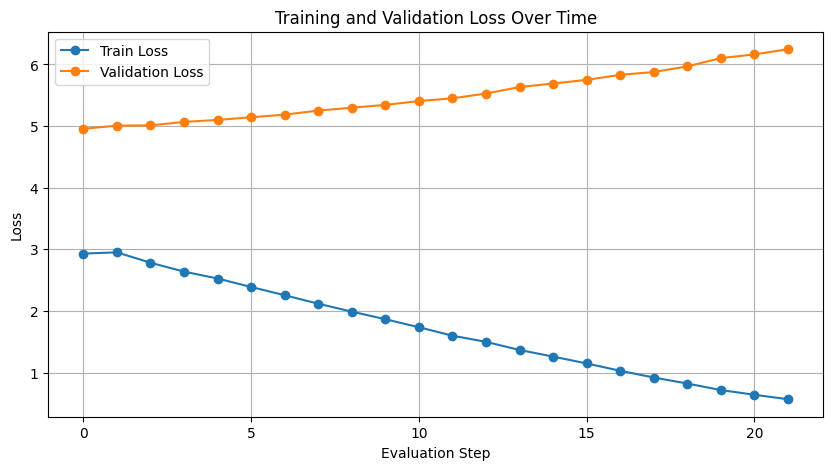

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss", marker='o')
plt.plot(val_losses, label="Validation Loss", marker='o')
plt.xlabel("Evaluation Step")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Time")
plt.legend()
plt.grid()
plt.show()

In [19]:
input_tokens = tokenizer.encode("Good morning bro ")
input_tokens = torch.tensor(
    input_tokens, dtype=torch.long).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    output = model.generate(input_tokens=input_tokens, max_new_tokens=100)

print(tokenizer.decode(output[0].tolist()))

Good morning bro why And I'm miarring What about thrush, I want everything in the meral devial trust And do you see the backend? Where is very good �I think solyes, I do not look down on my backend to anguessing you But I should asking for blly hemas it Since 14 Heo called it 😎� As so because I have not know what way you will cause he 
